# Medical Image - TFM
<h4>subtitle: Generación de una tubería distribuida para la extracción de características en imágenes médicas patológicas</h4>
license: European Union Public Licence (EUPL) v1.2

<table>
  <tr> <td> author name: </td> <td> Israel Llorens </td> </tr>
  <tr> <td> email: </td> <td> sanchezis@hotmail.com </td> </tr>
</table>

<h7>date: 2024/03/22</h7>

---

### Load

Carga de datos en las tablas de mongoDB? o en aluna localización en la que pueda trabajar,... primero analizar la imagen.

---

In [1]:
import numpy as np

import os
import xml.etree.cElementTree as ET
import random
import os 
import glob
import fsspec

from digital_pathology.helper_functions import *
from digital_pathology.utils import *

# from skimage import io
# import scipy as sp
# import skimage.io
# import skimage.measure
# import skimage.color
# import cv2 as cv
# import openslide
# import histomicstk as htk
# import histolab as hlb
# import tifffile
# from tiffslide import TiffSlide

# from histolab.slide import Slide
# from histolab.tiler import RandomTiler

import PIL
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

PIL.MAX_IMAGE_PIXELS = 92932669440
Image.MAX_IMAGE_PIXELS = None

In [2]:
import init
from digital_pathology.spark import spark

import pyspark.sql.functions as F
from pyspark.sql.types import StringType, StructType, ArrayType, StructField, TimestampType, LongType, BinaryType

In [3]:
ingestion = spark.read.parquet('out/0-extract.parquet')

ingestion = ingestion.withColumn('image',   F.regexp_extract ('filename',  '.*/(\w+\..*)', 1) ) 
ingestion.show(truncate=False)

+-----------------------------------+----+-----+----------+------------------+
|filename                           |type|loc  |project   |image             |
+-----------------------------------+----+-----+----------+------------------+
|CAMELYON16/masks/tumor_007_mask.tif|tif |masks|CAMELYON16|tumor_007_mask.tif|
|CAMELYON16/masks/tumor_008_mask.tif|tif |masks|CAMELYON16|tumor_008_mask.tif|
|CAMELYON16/masks/tumor_009_mask.tif|tif |masks|CAMELYON16|tumor_009_mask.tif|
|CAMELYON16/masks/tumor_010_mask.tif|tif |masks|CAMELYON16|tumor_010_mask.tif|
|CAMELYON16/masks/tumor_011_mask.tif|tif |masks|CAMELYON16|tumor_011_mask.tif|
|CAMELYON16/masks/tumor_012_mask.tif|tif |masks|CAMELYON16|tumor_012_mask.tif|
|CAMELYON16/masks/tumor_013_mask.tif|tif |masks|CAMELYON16|tumor_013_mask.tif|
|CAMELYON16/masks/tumor_014_mask.tif|tif |masks|CAMELYON16|tumor_014_mask.tif|
|CAMELYON16/masks/tumor_015_mask.tif|tif |masks|CAMELYON16|tumor_015_mask.tif|
|CAMELYON16/masks/tumor_016_mask.tif|tif |masks|CAME

## Extract Images

In [4]:
BINARY_FILES_SCHEMA = StructType(
    [
        StructField("path", StringType()),
        StructField("TimeStart", LongType()),
        StructField("TimeEnd", LongType()),
        StructField("modificationTime", TimestampType()),
        StructField("length", LongType()),
        StructField("bytes_string", StringType()),
        StructField("tiff_properties", StringType()),
        StructField("content", ArrayType(BinaryType())),
    ]
)

S3_PROJECT = 'camelyon-dataset'

In [5]:
import tifffile
from tiffslide import TiffSlide

# @F.pandas_udf(StringType())
@F.udf(returnType = BINARY_FILES_SCHEMA)
def download_attributes(col, img, DEBUG=True):
    import io
    import os
    import boto3
    import datetime
    import time

    start_ts = time.time_ns()
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(col) # 'camelyon-dataset'
    object = bucket.Object(img)

    buffer = None
    image = None
    slide = None

    if not DEBUG:    
        file_stream = io.BytesIO()
        object.download_fileobj(file_stream)
        buffer = bytearray(file_stream.getvalue())

    if buffer:
        image = tifffile.imread(buffer)
        slide = TiffSlide(buffer)

    return [ 
            os.path.join(col , img), 
            start_ts,
            time.time_ns(),
            datetime.datetime.now(), 
            len(buffer), 
            f"{len(buffer)//1024**2/1024} GB",
            slide.properties['tiff.ImageDescription'] if slide else None,
            [None,] 
            ] 

transform = ingestion\
    .filter( # (F.col('loc').like('image%')) &
            (F.col('project').like('CAMELYON17'))
            )\
    .withColumn('out_dir', F.concat_ws('/',  F.lit('out'), F.col('image') )  ) \
    .filter(    ( F.col('image').rlike(r'patient_0[0|1]')  ) |
                ( F.col('loc')=='') |
                ( F.col('type').isin( ['py','csv', 'txt'] ))
            )\
    .filter(  (F.col('image')!='') ) \
    .sort('image')

In [6]:
transform  .show(truncate=False, n=20)

+--------------------------------------------+----+----------+----------+---------------------------+-------------------------------+
|filename                                    |type|loc       |project   |image                      |out_dir                        |
+--------------------------------------------+----+----------+----------+---------------------------+-------------------------------+
|CAMELYON17/README.md                        |md  |          |CAMELYON17|README.md                  |out/README.md                  |
|CAMELYON17/checksums.md5                    |md5 |          |CAMELYON17|checksums.md5              |out/checksums.md5              |
|CAMELYON17/evaluation/evaluate.py           |py  |evaluation|CAMELYON17|evaluate.py                |out/evaluate.py                |
|CAMELYON17/evaluation/example.csv           |csv |evaluation|CAMELYON17|example.csv                |out/example.csv                |
|CAMELYON17/license.txt                      |txt |          |

## Code use to download 1 image in data folder from AWS CAMELYON data source

In [ ]:
# S3 configuration
bucket_name = 'camelyon-dataset'
s3_path = 'CAMELYON17/images/patient_013_node_0.tif'

# img = download_image(bucket_name, s3_path)

## Openslide

In [8]:
imgfile = f'../data/patient_013_node_0.tif'

import openslide
import io

image = tifffile.imread(imgfile)
slide = TiffSlide(imgfile)
oslide = openslide.OpenSlide(imgfile)

# Method 3: Use numpy directly
np_image = np.array(image)
print(f"Image dimensions: {np_image.shape}")
print(f"Image dtype: {np_image.dtype}")

Image dimensions: (197226, 96651, 3)
Image dtype: uint8


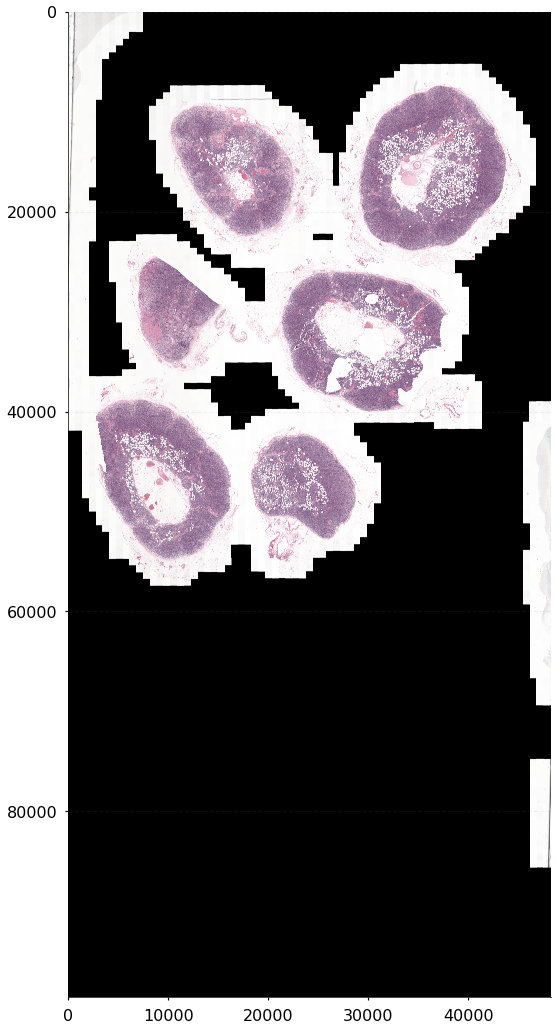

In [9]:
# Get the dimensions of the whole image at level 1
level = 1
image_width, image_height = slide.level_dimensions[level]

# Define the region as the entire image
region = (0, 0)
size = (image_width, image_height)

# Read and display the whole image
region = slide.read_region(region, level, size)
plt.figure(figsize=(20, 20))
plt.imshow(region)
plt.show()

In [13]:
import large_image

large_image.tilesource.loadTileSources()
print(large_image.tilesource.AvailableTileSources)

ts = large_image.tilesource.getTileSource(imgfile)
ts.getMetadata()

{'dicom': <class 'large_image_source_dicom.DICOMFileTileSource'>, 'multi': <class 'large_image_source_multi.MultiFileTileSource'>, 'rasterio': <class 'large_image_source_rasterio.RasterioFileTileSource'>, 'pil': <class 'large_image_source_pil.PILFileTileSource'>, 'test': <class 'large_image_source_test.TestTileSource'>, 'deepzoom': <class 'large_image_source_deepzoom.DeepzoomFileTileSource'>, 'nd2': <class 'large_image_source_nd2.ND2FileTileSource'>, 'zarr': <class 'large_image_source_zarr.ZarrFileTileSource'>, 'tifffile': <class 'large_image_source_tifffile.TifffileFileTileSource'>}


{'levels': 10,
 'sizeX': 96651,
 'sizeY': 197226,
 'tileWidth': 512,
 'tileHeight': 512,
 'magnification': 41.13638126388783,
 'mm_x': 0.0002430938184827319,
 'mm_y': 0.0002430938184827319,
 'dtype': 'uint8',
 'bandCount': 3}

In [14]:
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, 
    get_tissue_mask
    )

In [15]:
thumbnail_rgb = ts.getThumbnail()[0]

In [16]:
thumbnail_rgb = oslide.get_thumbnail((500,500))

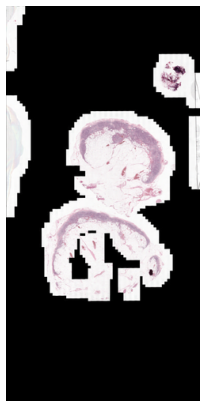

In [17]:
plt.axis('off')
plt.imshow(thumbnail_rgb)

## Sampling using openslide

In [20]:
from openslide.deepzoom import DeepZoomGenerator

tiles = DeepZoomGenerator(oslide)

In [28]:
tiles.level_count

19

In [45]:
tiles.level_tiles[10]

(2, 4)

In [50]:
tiles.level_tiles[10]

(2, 4)

In [62]:
from urllib import request
import certifi
import ssl

context = ssl.create_default_context(cafile=certifi.where())
https_handler = request.HTTPSHandler(context=context)
opener = request.build_opener(https_handler)
request.install_opener(opener)

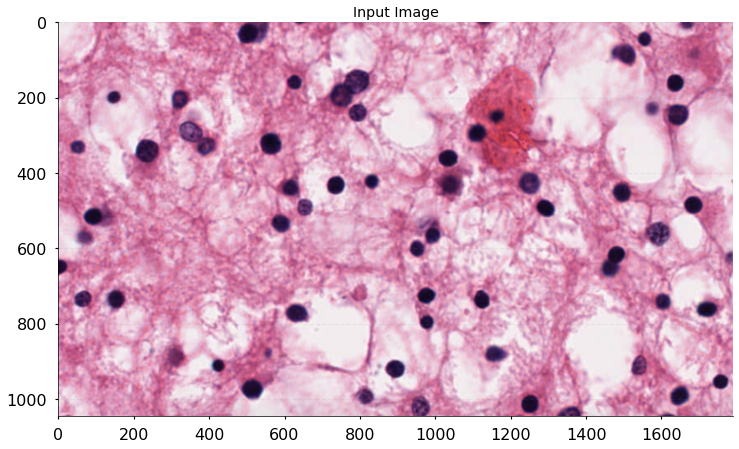

In [64]:
import skimage

input_image_file = ('https://data.kitware.com/api/v1/file/'
                    '576ad39b8d777f1ecd6702f2/download')  # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

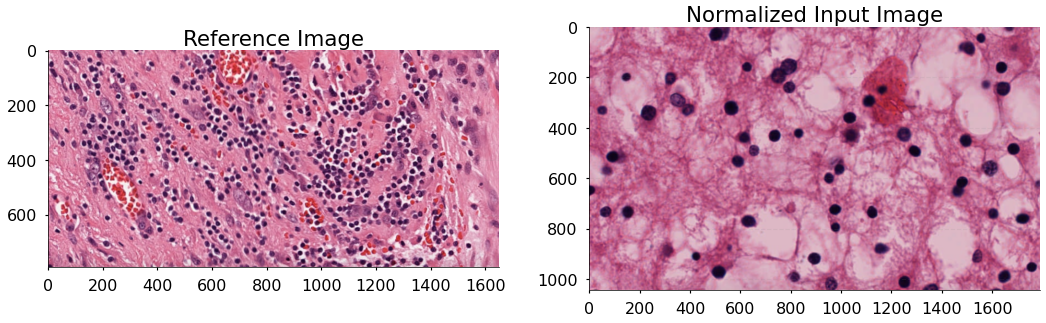

In [66]:
import histomicstk as htk

# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=24)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=24)

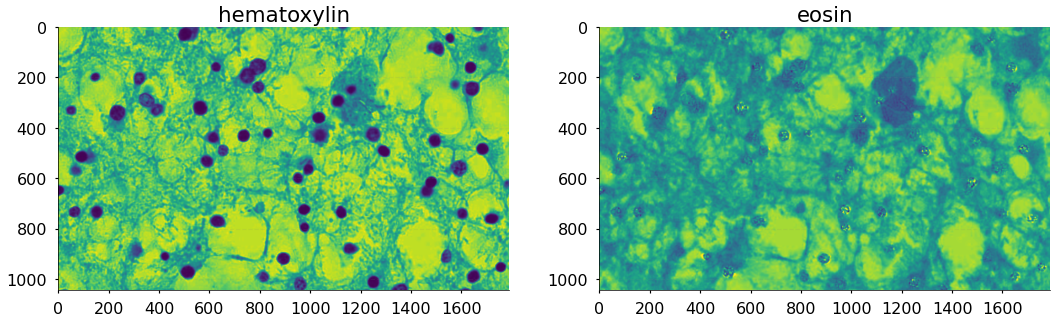

In [67]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=24)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=24)

Number of nuclei =  65


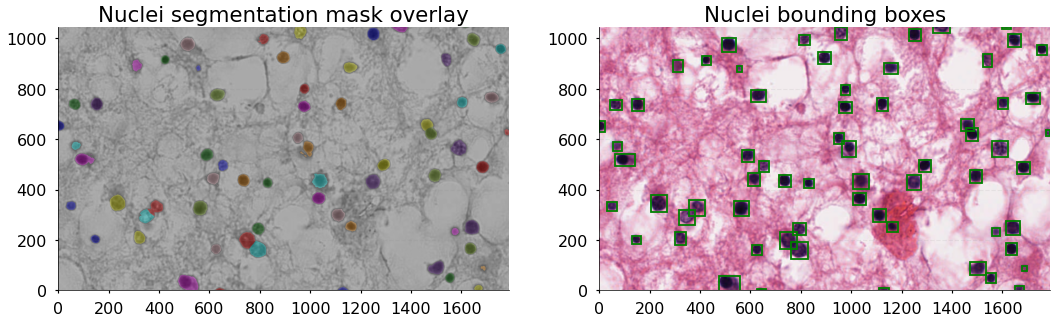

In [68]:
import scipy as sp

# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=24)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=24)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                                width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)